In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [ ]:
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/DLS-1/Project"

IMG_DIR       = os.path.join(BASE_DIR, "Selected")

SELECTED_CSV  = os.path.join(BASE_DIR, "selected_celeba.csv")

## Шаг 1

Читаем файлы с информацией о координатах bbox-ов и ключевых точек лица.
И визуализируем на случайно выбранном изображении.

In [ ]:
selected_df = pd.read_csv(SELECTED_CSV)

Image: 082233.jpg


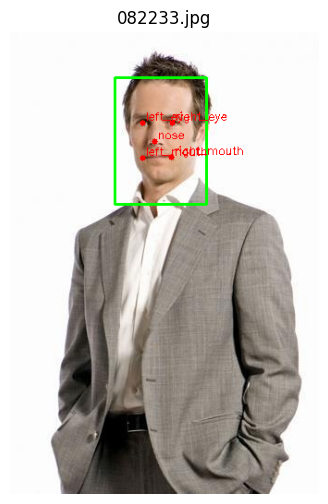

In [ ]:
# ====== Берём случайное изображение из selected ======
img_name = random.choice(selected_df.iloc[:, 0].values)
print("Image:", img_name)

image_row = selected_df[selected_df["image_id"] == img_name].iloc[0]

# ====== Получаем bbox ======
x, y, w, h = image_row[["x_1", "y_1", "width", "height"]]

# ====== Получаем landmarks ======
landmarks = {
    "left_eye":     (image_row["lefteye_x"],    image_row["lefteye_y"]),
    "right_eye":    (image_row["righteye_x"],   image_row["righteye_y"]),
    "nose":         (image_row["nose_x"],       image_row["nose_y"]),
    "left_mouth":   (image_row["leftmouth_x"],  image_row["leftmouth_y"]),
    "right_mouth":  (image_row["rightmouth_x"], image_row["rightmouth_y"]),
}

# ====== Загрузка изображения ======
img_path = os.path.join(IMG_DIR, img_name)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_vis = img.copy()

# ====== Рисуем bbox ======
cv2.rectangle(
    img_vis,
    (int(x), int(y)),
    (int(x + w), int(y + h)),
    color=(0, 255, 0),
    thickness=2
)

# ====== Рисуем и подписываем landmarks ======
for name, (lx, ly) in landmarks.items():
    cv2.circle(
        img_vis,
        (int(lx), int(ly)),
        radius=3,
        color=(255, 0, 0),
        thickness=-1
    )
    cv2.putText(
        img_vis,
        name,
        (int(lx) + 3, int(ly) - 3),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.4,
        (255, 0, 0),
        1
    )

# ====== Показываем ======
plt.figure(figsize=(6, 6))
plt.imshow(img_vis)
plt.axis("off")
plt.title(img_name)
plt.show()


## Шаг 2

Вырезаем лицо из изображения, выбранного на первом шаге.

Размеры bbox-а масштабируем (увеличиваем на 20%). Это будет нужно позднее, чтобы иметь запас для обрезания после будущего выравнивания лица. Вероятно, это и не обязательно было делать, но так решил и сделал.

Пересчитываем координаты ключевых точек лица.

Визуализируем вырезанное лицо и ключевые точки (пересчитанные координаты).

In [ ]:
H, W, _ = img.shape

# landmarks в виде массива, без наименований
landmarks = np.array([
    [image_row["lefteye_x"],    image_row["lefteye_y"]],
    [image_row["righteye_x"],   image_row["righteye_y"]],
    [image_row["nose_x"],       image_row["nose_y"]],
    [image_row["leftmouth_x"],  image_row["leftmouth_y"]],
    [image_row["rightmouth_x"], image_row["rightmouth_y"]],
], dtype=np.float32)


scale = 1.2 # увеличиваем размер рамки на 20%

cx = x + w / 2
cy = y + h / 2

new_w = w * scale
new_h = h * scale

x1 = int(max(cx - new_w / 2, 0))
y1 = int(max(cy - new_h / 2, 0))
x2 = int(min(cx + new_w / 2, W))
y2 = int(min(cy + new_h / 2, H))

In [ ]:
face_crop = img[y1:y2, x1:x2].copy()
crop_h, crop_w, _ = face_crop.shape

landmarks_crop = landmarks.copy()
landmarks_crop[:, 0] -= x1
landmarks_crop[:, 1] -= y1

print(H, W)
print(crop_h, crop_w)

500 334
164 118


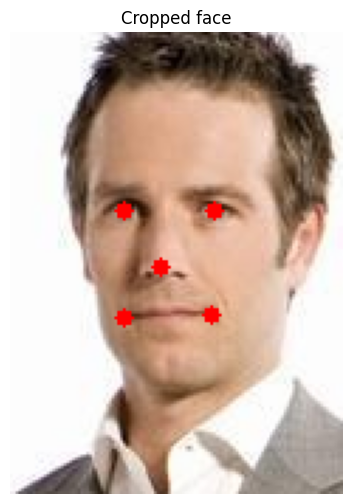

In [ ]:
crop_vis = face_crop.copy()

for (lx, ly) in landmarks_crop:
    cv2.circle(crop_vis, (int(lx), int(ly)), radius=3, color=(255, 0, 0), thickness=-1)

plt.figure(figsize=(6, 6))
plt.imshow(crop_vis)
plt.title("Cropped face")
plt.axis("off")
plt.show()

## Шаг 3

Ресайзим лицо до размера 256х256. Опять пересчитываем координаты ключевых точек лица.

Ресайз делал без геометрических искажений, путем вырезания максимального центрального квадрата. Это опять, вероятно, не было обязательно, т.к. при будущем выравнивании всё равно внесутся искажения в пропорции. Но, подумал, что не повредит.

Визуализируем результат ресайза с ключевыми точками.



In [ ]:
INPUT_SIZE = 256

min_size = min(crop_h, crop_w)  # Находим сторону максимального квадрата

# Вычисляем координаты начала (верхний левый угол)
start_x = (crop_w - min_size) // 2
start_y = (crop_h - min_size) // 2

# Вырезаем центральный квадрат
face_square = face_crop[start_y:start_y+min_size, start_x:start_x+min_size]

face_resized = cv2.resize(
    face_square,
    (INPUT_SIZE, INPUT_SIZE),
    interpolation=cv2.INTER_LINEAR
)

lm_scale = INPUT_SIZE / min_size

landmarks_resized = landmarks_crop.copy()

landmarks_resized[:, 0] -= start_x
landmarks_resized[:, 1] -= start_y

landmarks_resized[:, 0] *= lm_scale
landmarks_resized[:, 1] *= lm_scale

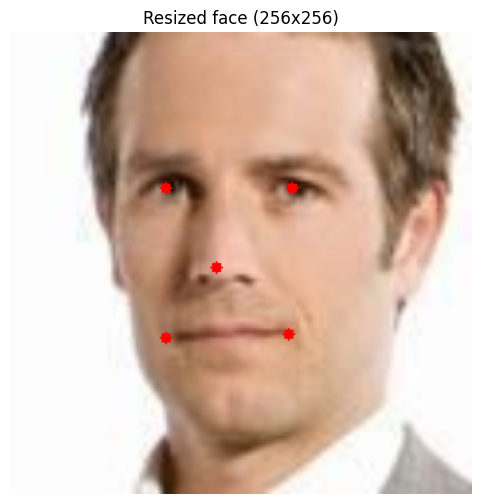

In [ ]:
resized_vis = face_resized.copy()

for (lx, ly) in landmarks_resized:
    cv2.circle(resized_vis, (int(lx), int(ly)), radius=3, color=(255, 0, 0), thickness=-1)

plt.figure(figsize=(6, 6))
plt.imshow(resized_vis)
plt.title("Resized face (256x256)")
plt.axis("off")
plt.show()

## Шаг 4

Тренируемся строить heatmap размера 64х64.

Визуализируем 5 heatmap-ов для каждой из 5 ключевых точек лица.

In [ ]:
HEATMAP_SIZE = 64
SIGMA = 2.0   # в пикселях heatmap'ы

def landmarks_to_heatmaps(landmarks,
                          heatmap_size=HEATMAP_SIZE,
                          input_size=INPUT_SIZE,
                          sigma=SIGMA):
    """
    landmarks: (NUM_LANDMARKS=5, 2) в координатах input_size x input_size
    return: heatmaps (NUM_LANDMARKS=5, heatmap_size, heatmap_size) в координатах heatmap_size x heatmap_size
    """
    # выделяем пямять под все heatmap-ы (в данном случае точек 5)
    heatmaps = np.zeros((landmarks.shape[0], heatmap_size, heatmap_size), dtype=np.float32)

    # вычисляем масштабный коэффициент пересчета координат: image coords -> heatmap coords
    scale = heatmap_size / input_size

    # создаём meshgrid для одной heatmap-ы
    xx, yy = np.meshgrid(np.arange(heatmap_size), np.arange(heatmap_size))

    # вычисляем в цикле heatmap для каждой точки в landmarks
    for i, (x, y) in enumerate(landmarks):

        x_hm = x * scale # scale from image coords -> heatmap coords
        y_hm = y * scale # scale from image coords -> heatmap coords

        # Обрезаем координаты, чтобы не выйти за пределы размеров heatmap-ы
        x_hm = min(max(0, int(x_hm)), heatmap_size - 1)
        y_hm = min(max(0, int(y_hm)), heatmap_size - 1)

        heatmaps[i] = np.exp(-((xx - x_hm) ** 2 + (yy - y_hm) ** 2) / (2 * sigma ** 2))

    return heatmaps

heatmaps = landmarks_to_heatmaps(landmarks_resized)
print(heatmaps.shape)

(5, 64, 64)


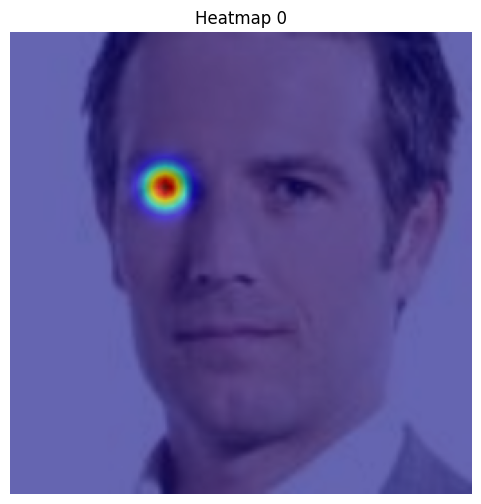

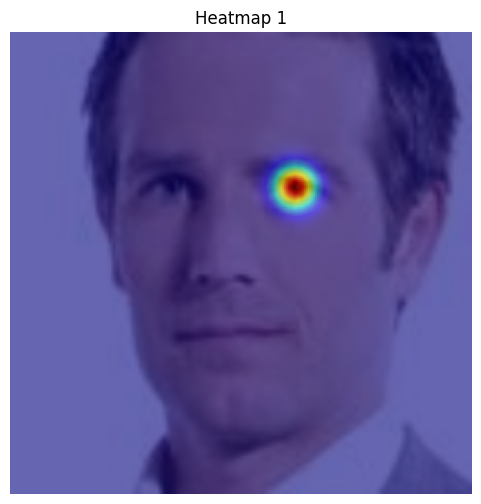

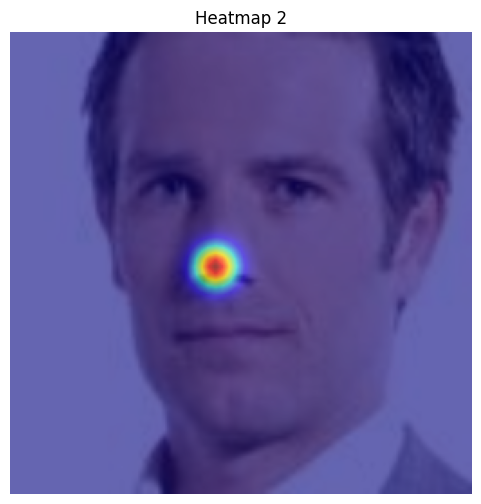

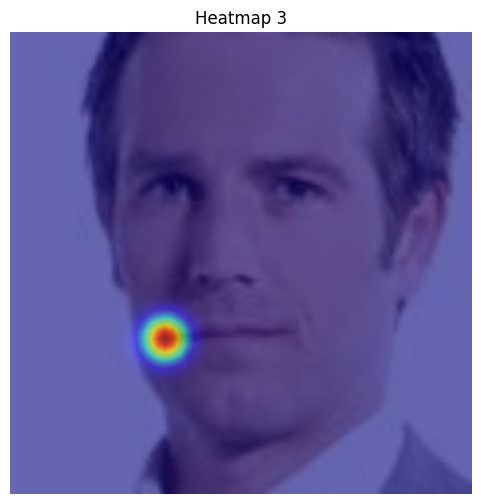

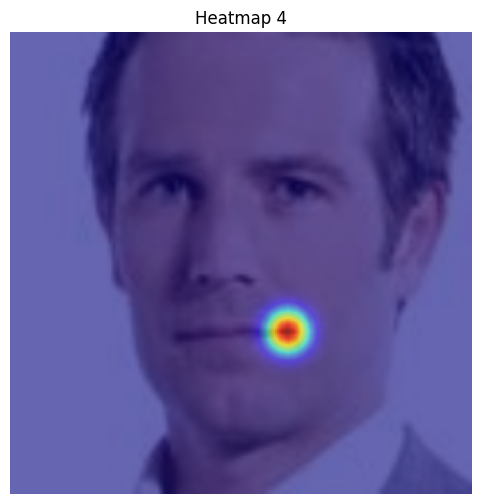

In [ ]:
NUM_LANDMARKS = 5

resized_vis = face_resized.copy()

def upsample_heatmap(hm, target_size=INPUT_SIZE):
    return cv2.resize(hm, (target_size, target_size), interpolation=cv2.INTER_LINEAR)

for i in range(NUM_LANDMARKS):
    hm = heatmaps[i]
    hm_up = upsample_heatmap(hm, INPUT_SIZE)

    # нормализация, т.е. приведение значений в heatmap-е к диапазону [0..1)
    hm_norm = (hm_up - hm_up.min()) / (hm_up.max() - hm_up.min() + 1e-6)

    plt.figure(figsize=(6, 6))
    plt.imshow(resized_vis)
    plt.imshow(hm_norm, alpha=0.6, cmap="jet")
    plt.title(f"Heatmap {i}")
    plt.axis("off")
    plt.show()
